In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import subprocess
import io
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import h5py
import toml
from tqdm.auto import tqdm
from markovids import pcl, vid, depth

## User functions

In [3]:
def lp_filter(x, sigma):
    return cv2.GaussianBlur(x, [0, 0], sigma, sigma)

def bp_filter(x, sigma1, sigma2, clip=True):
    if (sigma1 == 0) or (sigma1 is None):
        return x
    elif (sigma2 == 0) or (sigma2 is None):
        return lp_filter(x, sigma1)
    else:
        return np.clip(
            lp_filter(x, sigma1) - lp_filter(x, sigma2),
            0 if clip == True else -np.inf,
            np.inf,
        )

# Load in metadata

In [4]:
# original_data_dir = "/home/jmarkow/data_dir/active_projects/quantum_dots/timecourse_02/"
original_data_dir = "/home/jmarkow/data_dir/active_projects/quantum_dots/timecourse_02_joints/"
output_dir = "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/_labels/"

In [5]:
os.makedirs(output_dir, exist_ok=True)

# Gather all data files

In [6]:
import glob
dat_paths_reflect = sorted(glob.glob(os.path.join(original_data_dir, "**", "*reflectance.avi"), recursive=True))

# Get what already exists on segments

1. Get old labels
2. Get segments.ai labels
3. Merge everything
4. Save per camera keypoints
5. Don't need to save any images, should be fast

In [7]:
import json

from sleap.instance import LabeledFrame, PredictedInstance, Instance, PointArray, Point
from sleap import Labels, Video, Skeleton

from segments import SegmentsClient
import json

# You can find your api key at https://segments.ai/account
api_key = "XXX"
client = SegmentsClient(api_key)

2024-08-12 14:15:36.746954: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jmarkow/miniconda3/envs/sleap-analysis/lib/python3.10/site-packages/cv2/../../lib64:
2024-08-12 14:15:36.746985: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


INFO:segments.client:Initialized successfully.


In [8]:
exclude_paths = [
    "session_20240610170622-119479"
]

In [9]:
dataset_name = "jmarkow/basler-nir-plexiglass-arena-keypoints-fused-kneejoints" 
samples = client.get_samples(dataset_name, per_page=10000, label_status=["LABELED", "REVIEWED"]) # LABELED/REVIEWED
pre_segments_labels = [(client.get_label(_sample.uuid), _sample) for _sample in samples]

In [10]:
len(samples)

822

In [11]:
segments_labels = []
for _label in pre_segments_labels:
    to_add = True
    for _path in exclude_paths:
        if _path in _label[1].metadata["dat_path_fluo"]:
            to_add = False

    if to_add:
        segments_labels.append(_label)

In [12]:
from collections import defaultdict
leaderboard = defaultdict(int)
chk_labels = segments_labels
for _label, _sample in chk_labels:
    leaderboard[_label.created_by] += 1
    # break

In [13]:
leaderboard

defaultdict(int, {'jmarkow': 822})

In [14]:
# write out frames to new avi file for loading

In [15]:
uniq_files = sorted(list(set([_[1].metadata["dat_path_reflect"] for _ in segments_labels])))

In [16]:
segments_dset = client.get_dataset(dataset_name)
segments_cats = segments_dset.task_attributes.categories
segments_id_map = {_cat.id: _cat.name for _cat in segments_cats}

In [17]:
# set up skeleton
use_skeleton = Skeleton("markolab-skeleton-v0")
[use_skeleton.add_node(_name) for _name in segments_id_map.values()]
is_joints = False
if "hindleg_L" in segments_id_map.values():
    use_skeleton.add_edge("hindleg_L", "back_bottom")
    use_skeleton.add_edge("hindleg_R", "back_bottom")
    use_skeleton.add_edge("tail_tip", "tail_middle")
    use_skeleton.add_edge("tail_middle", "tail_base")
    use_skeleton.add_edge("tail_base", "back_bottom")
    use_skeleton.add_edge("back_bottom", "back_middle")
    use_skeleton.add_edge("back_middle", "back_top")
    use_skeleton.add_edge("foreleg_L", "back_top")
    use_skeleton.add_edge("foreleg_R", "back_top")
    use_skeleton.add_symmetry("foreleg_L","foreleg_R")
    use_skeleton.add_symmetry("hindleg_L","hindleg_R")
elif "knee_L" in segments_id_map.values():
    is_joints = True
    use_skeleton.add_symmetry("knee_L","knee_R")

In [18]:
# get some essentials
reader = vid.io.AutoReader(dat_paths_reflect[0])

In [19]:
writer_kwargs = {"frame_size": reader.frame_size,
                 "dtype": reader.dtype,
                 "fps": reader.fps,
                 "pixel_format": reader.pixel_format}

In [20]:
reader.close()

In [23]:
bground_path = "_bground"

In [24]:
# bpass = [None, (1, 3), (1, 5)]
bpass = [None]
weights = [
    None,
    (0.0, 1.0),
    # (0.25, 0.75),
    # (0.5, 0.5),
    # (0.75, 0.25),
    (1.0, 0.0),
]  # fluo vs reflect weights
force = True
for _bpass in tqdm(bpass):
    for _weights in tqdm(weights):
        if is_joints:
            save_path = os.path.join(
                output_dir, f"train_frames_kneejoints_fused_weights-{_weights}_bpass-{_bpass}.avi"
            )
        else:
            save_path = os.path.join(
                output_dir, f"train_frames_fused_weights-{_weights}_bpass-{_bpass}.avi"
            )
        if os.path.exists(save_path) and (not force):
            continue

        save_path_sleap = os.path.splitext(save_path)[0] + ".slp"
        save_path_metadata = os.path.splitext(save_path)[0] + ".toml"

        writer_kwargs["pixel_format"] = "bgr24" if _weights is None else "gray"
        writer = vid.io.AviWriter(save_path, **writer_kwargs)
        vid_obj = Video.from_filename(save_path, grayscale=(not _weights is None))

        cur_idx = 0
        all_labeled_frames = []
        all_segments_metadata = {"segments_metadata" : []}
        for _file in tqdm(uniq_files):
            use_labels = [
                (_label, _sample)
                for _label, _sample in segments_labels
                if _sample.metadata["dat_path_reflect"] == _file
            ]
            use_frames = [
                _sample.metadata["frame_index"] for _label, _sample in use_labels
            ]

            fluo_fname = _file.replace("-reflectance.avi", "-fluorescence.avi")

            reflect_reader = vid.io.AutoReader(_file)
            fluo_reader = vid.io.AutoReader(fluo_fname)
            reflect_frames = reflect_reader.get_frames(use_frames)
            fluo_frames = fluo_reader.get_frames(use_frames).copy()
            reflect_reader.close()
            fluo_reader.close()

            dirname = os.path.dirname(_file)
            bground_fname = os.path.splitext(os.path.basename(fluo_fname))[0]
            use_bground_path = os.path.join(
                dirname, bground_path, f"{bground_fname}.hdf5"
            )

            with h5py.File(use_bground_path, "r") as f:
                rolling_bgrounds = f["bground"][()]
                idxs = f["frame_idxs"][()]

            for i, (_idx, _frame) in enumerate(zip(use_frames, fluo_frames)):
                use_bground = np.argmin(np.abs(idxs - _idx))
                fluo_frames[i] = np.clip(
                    _frame - rolling_bgrounds[use_bground], 0, 255
                ).astype("uint8")

            if _weights is not None:
                write_frames = np.zeros_like(reflect_frames)

                for i, (_reflect, _fluo) in enumerate(zip(reflect_frames, fluo_frames)):
                    frame_index = use_frames[i]

                    if _bpass is not None:
                        proc_fluo = bp_filter(_fluo.astype("float32"), *_bpass)
                    else:
                        proc_fluo = _fluo.astype("float32")
                    proc_fluo[proc_fluo <= 0] = 0

                    if _weights[1] == 1:
                        new_im = _reflect.astype("uint8") # skip normalization if we're not combining
                    elif _weights[0] == 1:
                        new_im = proc_fluo.astype("uint8") # skip normalization if we're not combining
                    else:
                        new_im = _weights[0] * proc_fluo + _weights[1] * _reflect
                        new_im = (new_im - new_im.min()) / (new_im.max() - new_im.min())
                        new_im *= 255
                        new_im = new_im.astype("uint8")

                    write_frames[i] = new_im
            else:
                write_frames = np.zeros(
                    (
                        reflect_frames.shape[0],
                        reflect_frames.shape[1],
                        reflect_frames.shape[2],
                        3, # bgr
                    ),
                    dtype="uint8",
                )
                for i, (_reflect, _fluo) in enumerate(zip(reflect_frames, fluo_frames)):

                    if _bpass is not None:
                        proc_fluo = bp_filter(_fluo.astype("float32"), *_bpass)
                    else:
                        proc_fluo = _fluo.astype("float32")
                    proc_fluo[proc_fluo <= 0] = 0
                    
                    write_frames[i][...,0] = proc_fluo.astype("uint8")
                    write_frames[i][...,1] = _reflect
                    write_frames[i][...,2] = _reflect

            for (_label, _sample), _frame in zip(use_labels, write_frames):
                use_points = {}
                for _annotation in _label.attributes.annotations:
                    x, y = _annotation.points[0]
                    name = segments_id_map[_annotation.category_id]
                    common_name = name.split(" ")[0]
                    use_points[common_name] = Point(
                        x=x, y=y, visible=True, complete=True
                    )
                if len(use_points) > 0:
                    # only write a frame if we're here...
                    writer.write_frames([_frame], progress_bar=False)
                    instance = Instance(skeleton=use_skeleton, points=use_points)
                    labeled_frame = LabeledFrame(
                        video=vid_obj, instances=[instance], frame_idx=cur_idx
                    )
                    all_labeled_frames.append(labeled_frame)

                    # metadata to stash
                    metadata = {
                        "uuid": _sample.uuid,        
                        "dat_path_fluo": _sample.metadata["dat_path_fluo"],    
                        "dat_path_reflect": _sample.metadata["dat_path_reflect"],
                        "img_path": _sample.metadata["img_path"],
                        "frame_index": _sample.metadata["frame_index"],
                        "camera": _sample.metadata["camera"],
                        "pad": _sample.metadata["pad"],
                        "dataset_index": len(all_labeled_frames) - 1
                    }
                    all_segments_metadata["segments_metadata"].append(metadata)
                    cur_idx += 1

            # read in frames, map to avi etc.

        writer.close()
        labels = Labels(all_labeled_frames)
        print(f"n(labels) {len(labels)}")
        with open(save_path_metadata, "w") as f:
            toml.dump(all_segments_metadata, f)
        labels.save(save_path_sleap, with_images=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

n(labels) 822


  0%|          | 0/5 [00:00<?, ?it/s]

n(labels) 822


  0%|          | 0/5 [00:00<?, ?it/s]

n(labels) 822


In [25]:
instance

Instance(video=Video(filename=/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/_labels/train_frames_kneejoints_fused_weights-(1.0, 0.0)_bpass-None.avi, shape=(822, 1023, 1008, 1), backend=MediaVideo), frame_idx=821, points=[knee_R: (327.4, 549.2)], track=None)

In [26]:
instance = labels[2].instances[0]

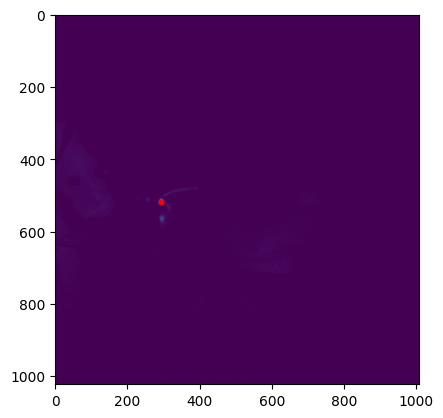

In [27]:
plt.imshow(labels[2].image[:,:,0])
for _point in instance.points:
    # pass
    plt.scatter(_point.x, _point.y, s=10, c="r")